# Real Dataset

[Available Here](https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system)

The following data set is from the Centers for Disease Control and Prevention (CDC) and includes socioeconomic and lifestyle indicators for hundreds of thousands of individuals. The objective is to predict the overall health of an individual: either 0 for poor health or 1 for good health. I limited the data to 100,000 individuals to speed up training. 

The problem is imbalanced (far more of one label than another) so for assessing performance, I'll use recall, precision, receiver operating characteristic area under the curve (ROC AUC), and also plot the ROC curve. 

## Data Cleaning 

I'll read the data in and did a little cleaning. 

In [0]:
df = pd.read_csv('data/2015_health.csv').sample(100000, random_state = RSEED)
df.head()

_STATE  FMONTH        IDATE IMONTH   IDAY    IYEAR  DISPCODE  \
383119    49.0     4.0  b'05192015'  b'05'  b'19'  b'2015'    1100.0   
55536      9.0     9.0  b'09232015'  b'09'  b'23'  b'2015'    1100.0   
267093    34.0    10.0  b'11052015'  b'11'  b'05'  b'2015'    1100.0   
319092    41.0     4.0  b'04062015'  b'04'  b'06'  b'2015'    1100.0   
420978    54.0     5.0  b'05112015'  b'05'  b'11'  b'2015'    1100.0   

               SEQNO          _PSU  CTELENUM    ...     _PAREC1  _PASTAE1  \
383119  2.015009e+09  2.015009e+09       NaN    ...         4.0       2.0   
55536   2.015005e+09  2.015005e+09       1.0    ...         2.0       2.0   
267093  2.015011e+09  2.015011e+09       NaN    ...         4.0       2.0   
319092  2.015002e+09  2.015002e+09       1.0    ...         2.0       2.0   
420978  2.015004e+09  2.015004e+09       NaN    ...         1.0       1.0   

        _LMTACT1  _LMTWRK1  _LMTSCL1  _RFSEAT2  _RFSEAT3  _FLSHOT6  _PNEUMO2  \
383119       3.0       3.0       4.0       1.0       1.0       NaN       NaN   
55536        3.0       3.0       4.0       1.0       1.0       NaN       NaN   
267093       3.0       3.0       4.0       1.0       1.0       NaN       NaN   
319092       2.0       2.0       3.0       1.0       1.0       2.0       1.0   
420978       3.0       3.0       4.0       1.0       1.0       NaN       NaN   

        _AIDTST3  
383119       2.0  
55536        2.0  
267093       2.0  
319092       2.0  
420978       2.0  

[5 rows x 330 columns]

In [0]:
df = df.select_dtypes('number')

### Label Distribution

In [0]:
df['_RFHLTH'] = df['_RFHLTH'].replace({2: 0})
df = df.loc[df['_RFHLTH'].isin([0, 1])].copy()
df = df.rename(columns = {'_RFHLTH': 'label'})
df['label'].value_counts()

1.0    81140
0.0    18579
Name: label, dtype: int64

Below, I dropped a number of columns that I will not use for modeling (they are different versions of the labels).

In [0]:
# Remove columns with missing values
df = df.drop(columns = ['POORHLTH', 'PHYSHLTH', 'GENHLTH', 'PAINACT2', 
                        'QLMENTL2', 'QLSTRES2', 'QLHLTH2', 'HLTHPLN1', 'MENTHLTH'])

## Split Data into Training and Testing Set

The ratio of train to test set by me is 70:30.

In [0]:
from sklearn.model_selection import train_test_split

# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

#### Imputation of Missing values


In [0]:
train = train.fillna(train.mean())
test = test.fillna(test.mean())

# Features for feature importances
features = list(train.columns)

In [0]:
train.shape

(69803, 313)

In [0]:
test.shape

(29916, 313)

## Decision Tree on Real Data

In [0]:
# Train tree
tree.fit(train, train_labels)
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

Decision tree has 12327 nodes with maximum depth 55.


## Assess Decision Tree Performance


In [0]:
# Make probability predictions
train_probs = tree.predict_proba(train)[:, 1]
probs = tree.predict_proba(test)[:, 1]

train_predictions = tree.predict(train)
predictions = tree.predict(test)

In [0]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(train_labels, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(test_labels, probs)}')

Train ROC AUC Score: 1.0
Test ROC AUC  Score: 0.6639844451938421


In [0]:
print(f'Baseline ROC AUC: {roc_auc_score(test_labels, [1 for _ in range(len(test_labels))])}')

Baseline ROC AUC: 0.5


## Evaluate the Decision Tree

The function also plots the ROC curve where a better model is to the left and towards the top. 

In [0]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');


In [0]:
from collections import Counter
print(Counter(probs))
print(Counter(predictions))

Counter({1.0: 23140, 0.0: 6776})
Counter({1.0: 23140, 0.0: 6776})


Recall Baseline: 1.0 Test: 0.83 Train: 1.0
Precision Baseline: 0.81 Test: 0.88 Train: 1.0
Roc Baseline: 0.5 Test: 0.66 Train: 1.0


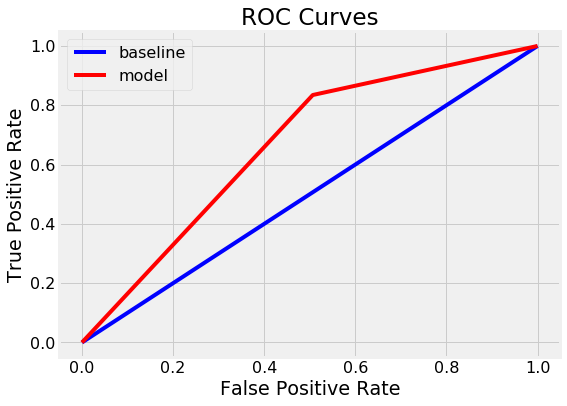

In [0]:
evaluate_model(predictions, probs, train_predictions, train_probs)

### Confusion Matrix

In [0]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[ 2750  2824]
 [ 4026 20316]]


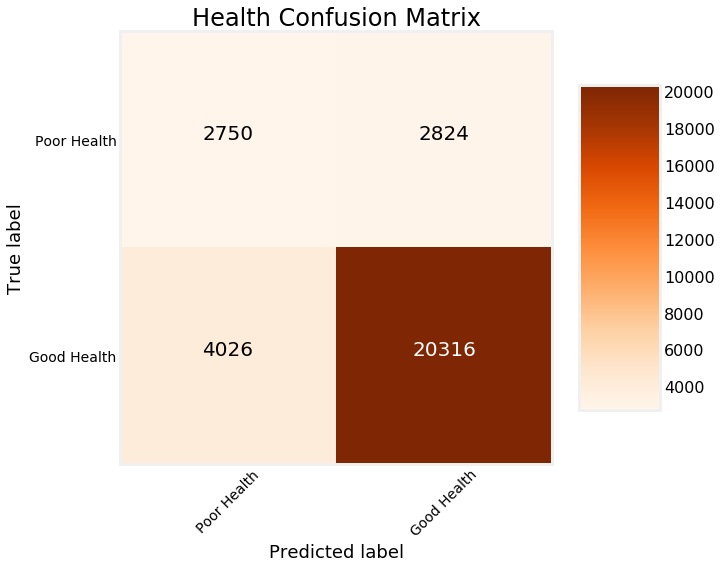

In [0]:
cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')

### Feature Importances
 

In [0]:
fi = pd.DataFrame({'feature': features,
                   'importance': tree.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()

feature  importance
62   DIFFWALK    0.191702
58   QLACTLM2    0.030550
51    EMPLOY1    0.023743
64   DIFFALON    0.018419
245     _BMI5    0.016785

In [0]:
# Save tree as dot file
export_graphviz(tree, 'tree_real_data.dot', rounded = True, 
                feature_names = features, max_depth = 6,
                class_names = ['poor health', 'good health'], filled = True)

# Convert to png
call(['dot', '-Tpng', 'tree_real_data.dot', '-o', 'tree_real_data.png', '-Gdpi=200'])

# Visualize
Image(filename='tree_real_data.png')

# Random Forest 

This takes the idea of a single decision tree, and creates an _ensemble_ model out of hundreds or thousands of trees to reduce the variance. Each tree is trained on a random set of the observations, and for each split of a node, only a subset of the features are used for making a split. When making predictions, the random forest averages the predictions for each of the individual decision trees for each data point in order to arrive at a final classification.

In [0]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=50, verbose=1, warm_start=False)

In [0]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 13396
Average maximum depth 46


## Random Forest Results

In [0]:
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


Recall Baseline: 1.0 Test: 0.96 Train: 1.0
Precision Baseline: 0.81 Test: 0.88 Train: 1.0
Roc Baseline: 0.5 Test: 0.87 Train: 1.0


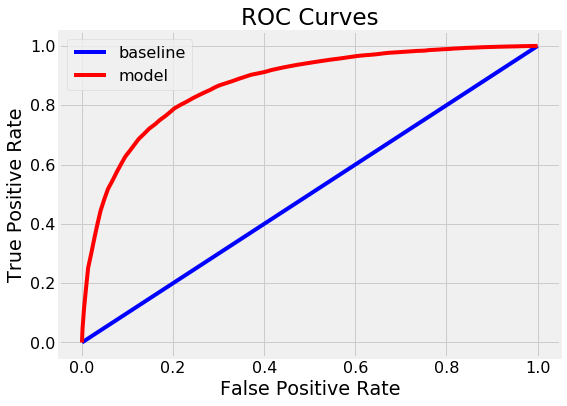

In [0]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)
Recall Baseline: 1.0 Test: 0.96 Train: 1.0
Precision Baseline: 0.81 Test: 0.88 Train: 1.0
Roc Baseline: 0.5 Test: 0.87 Train: 1.0

Confusion matrix, without normalization
[[ 2438  3136]
 [ 1044 23298]]


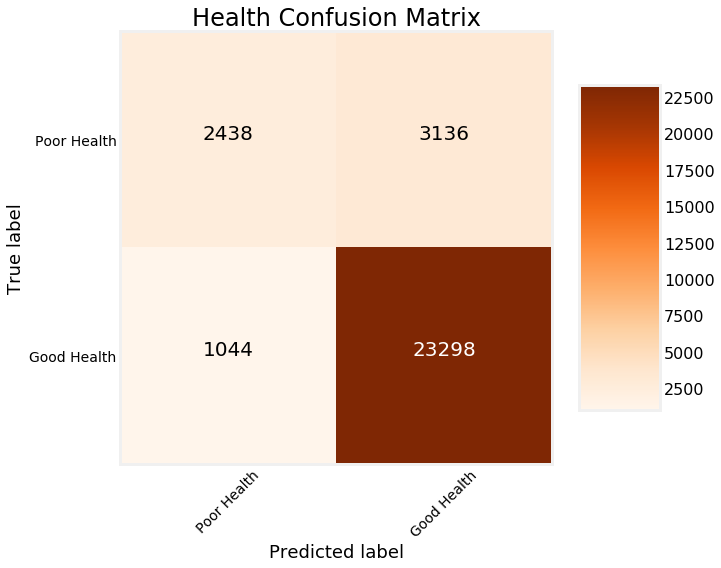

In [0]:
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')

Compared to the single decision tree, the model has fewer false postives although more false negatives. __Overall, the random forest does significantly better than a single decision tree__.

In [0]:
fi_model = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(10)

feature  importance
62   DIFFWALK    0.036200
58   QLACTLM2    0.030694
51    EMPLOY1    0.024156
64   DIFFALON    0.022699
59   USEEQUIP    0.016922
61     DECIDE    0.016271
307  _LMTSCL1    0.013424
53    INCOME2    0.011929
37   CHCCOPD1    0.011506
245     _BMI5    0.011497